In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [36]:
water_level_url = "GLHYD_data_metric.csv"
evaporation_url = "evaporation-ont.csv"
precipitation_url = "prc_ont_lake_mon.csv"
runoff_url = "runoff-ont.csv"


water_level_df = pd.read_csv(water_level_url)
evaporation_df = pd.read_csv(evaporation_url)
precipitation_df = pd.read_csv(precipitation_url)
runoff_df = pd.read_csv(runoff_url)


## Water Level Preprocessing

In [37]:


water_level_df = water_level_df.iloc[11:, :] # Remove notes from dataframe
water_level_df.columns = water_level_df.iloc[0,:] # rename columns
water_level_df = water_level_df.reset_index().drop(columns = "index") # reset index
water_level_df.columns.name = "" # Rename index column
water_level_df = water_level_df.iloc[1:, :] # Ensure "year" col is numeric
water_level_df["year"] = water_level_df["year"].astype(int) # convert "year" col to integers
water_level_df = water_level_df[water_level_df['year'] >= 1950].reset_index().drop(columns= "index") #subset data so it starts at 1940
water_level_df['month'] = water_level_df['month'].map({'jan' : 1,
                                                        'feb' : 2,
                                                        'mar' : 3,
                                                        'apr' : 4,
                                                        'may' : 5,
                                                        'jun' : 6,
                                                        'jul' : 7,
                                                        'aug' : 8,
                                                        'sep' : 9,
                                                        'oct' : 10,
                                                        'nov' : 11,
                                                        'dec' : 12
                                                        }) # Rename months to corresponding integers
water_level_df = pd.melt(frame = water_level_df,
                         id_vars= ["month", "year"],
                         value_vars= ["Superior", "Michigan-Huron", "St. Clair", "Erie", "Ontario"],
                         var_name= "lake",
                         value_name= "water level"
                         ) # Make each lake a value in new column "lake"
water_level_df = water_level_df[water_level_df['year'] <= 2020].reset_index().drop(columns= "index")
water_level_df.shape


(4260, 4)

## Evaporation Preprocessing

In [38]:
evaporation_df = pd.melt(frame = evaporation_df,
                         id_vars= "YYYY",
                         value_vars= evaporation_df.columns[1:],
                         var_name= "month",
                         value_name= "evaporation") # Make Months a value in the DF

evaporation_df = evaporation_df.rename(columns= {"YYYY" : "year"}) # Change name of year column

# Since we are assuming that evaporation is constant for all the lakes, we are going to extend this DF so that each lake as the same evaporation.

evaporation_df = pd.concat([evaporation_df] * 5, ignore_index= True)

evaporation_df.head()



,year,month,evaporation
0,1950,Jan,101.10
1,1951,Jan,89.08
2,1952,Jan,82.57
3,1953,Jan,89.67
4,1954,Jan,125.15


## Runoff Preprocessing

In [39]:
runoff_df = runoff_df[runoff_df["Year"] >= 1950]
runoff_df = runoff_df.reset_index().drop(columns = ["index", runoff_df.columns[5]])
runoff_df = pd.concat([runoff_df] * 5, ignore_index= True)
runoff_df

,Year,Mon,Flow,%gauged,#gauges
0,1950,1,1612.18,45.90,10.00
1,1950,2,951.42,45.90,10.00
2,1950,3,2100.59,45.90,10.00
3,1950,4,3057.59,45.90,10.00
4,1950,5,868.02,45.90,10.00
...,...,...,...,...,...
4255,2020,8,270.27,42.64,11.00
4256,2020,9,-999.99,-999.99,-999.99
4257,2020,10,-999.99,-999.99,-999.99
4258,2020,11,-999.99,-999.99,-999.99


## Precipitation Preprocessing

In [40]:
precipitation_df = pd.melt(frame = precipitation_df,
                           id_vars= "YYYY",
                           value_vars= precipitation_df.columns[1:],
                           var_name= "month",
                           value_name= "precipitation") # Turn Month into col values
precipitation_df = precipitation_df.rename(columns= {"YYYY" : "year"}) # rename year column
precipitation_df = precipitation_df[(precipitation_df["year"] >= 1950) & (precipitation_df["year"] <= 2020)] #subset df for 1950 - 2020
precipitation_df = precipitation_df.reset_index().drop(columns = "index")
precipitation_df = pd.concat([precipitation_df] * 5, ignore_index= True)
precipitation_df.shape



(4260, 3)

# New DataFrame

Water level, evaporation, runoff, precipiation

In [41]:
df = pd.concat([water_level_df, evaporation_df, runoff_df, precipitation_df], axis = 1)
df = df.loc[:, ~df.columns.duplicated()]
df = df.drop(columns= "Mon").reset_index().drop(columns = ["index", "Year"])
df = df.rename(columns= {df.columns[5] : "flow"})
print(df.head())
print(df.columns.to_list())
print((df['lake']).unique())

# Clean column names by removing leading/trailing spaces
df.columns = df.columns.str.strip()

# Now you can safely drop the columns
df = df.drop(columns=['%gauged', '#gauges'], inplace=False)

# Print the updated DataFrame
# print(df)
# print(df.columns)

df["precipitation"] = pd.to_numeric(df["precipitation"], errors="coerce")
df["evaporation"] = pd.to_numeric(df["evaporation"], errors="coerce")
df["flow"] = pd.to_numeric(df["flow"], errors="coerce")
df["water level"] = pd.to_numeric(df["water level"], errors="coerce")


# print(df.dtypes)

df_temp = df[df["lake"] == "Ontario"]

print(df_temp)

   month  year      lake water level  evaporation     flow   %gauged  \
0      1  1950  Superior      183.42       101.10  1612.18      45.9   
1      2  1950  Superior      183.37        89.08   951.42      45.9   
2      3  1950  Superior      183.33        82.57  2100.59      45.9   
3      4  1950  Superior      183.37        89.67  3057.59      45.9   
4      5  1950  Superior      183.57       125.15   868.02      45.9   

    #gauges precipitation  
0      10.0        106.56  
1      10.0         68.37  
2      10.0          66.2  
3      10.0         62.78  
4      10.0         59.98  
['month', 'year', 'lake', 'water level', 'evaporation', 'flow', ' %gauged', ' #gauges', 'precipitation']
['Superior' 'Michigan-Huron' 'St. Clair' 'Erie' 'Ontario']
      month  year     lake  water level  evaporation     flow  precipitation
3408      1  1950  Ontario        74.52       101.10  1612.18         106.56
3409      2  1950  Ontario        74.68        89.08   951.42          68.37
3410

In [42]:
# Filter the DataFrame for each lake
lakes = df["lake"].unique()
lake_dfs = {lake: df[df["lake"] == lake].reset_index(drop=True) for lake in lakes}

# Example: Access the DataFrame for Lake Superior
lake_superior_df = lake_dfs["Superior"]
lake_superior_df.dtypes


month              int64
year               int64
lake              object
water level      float64
evaporation      float64
flow             float64
precipitation    float64
dtype: object

In [43]:
lake_superior_df['water level']

0      183.42
1      183.37
2      183.33
3      183.37
4      183.57
        ...  
847    183.81
848    183.79
849    183.76
850    183.71
851    183.63
Name: water level, Length: 852, dtype: float64

# Lake Model VS 1

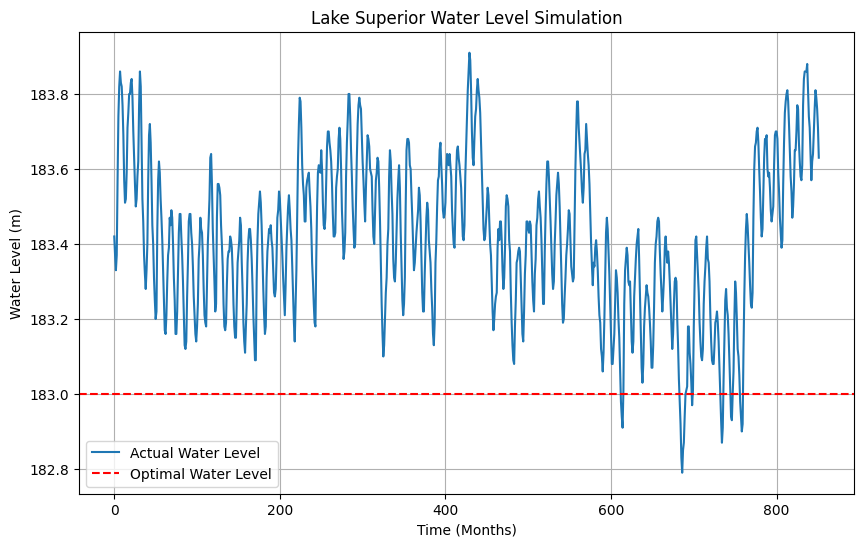

In [44]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(lake_superior_df['water level'], label = 'Actual Water Level')
plt.axhline(y=183, color='red', linestyle='--', label='Optimal Water Level')
plt.title("Lake Superior Water Level Simulation")
plt.xlabel("Time (Months)")
plt.ylabel("Water Level (m)")
plt.legend()
plt.grid()
plt.show()

Initial water level: 183.42


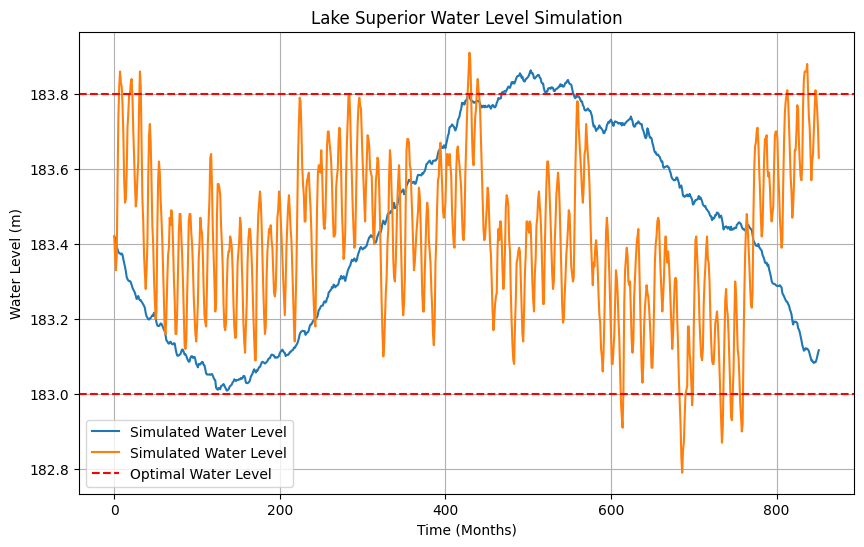

In [45]:
import matplotlib.pyplot as plt

# Function to simulate water level for a lake
def simulate_water_level(lake_df, initial_level, alpha, beta, gamma):
    levels = [initial_level]
    for t in range(1, len(lake_df)):
        precipitation = lake_df.loc[t, "precipitation"]
        evaporation = lake_df.loc[t, "evaporation"]
        flow = lake_df.loc[t, "flow"]
        # Compute water level change
        delta_H = (alpha * precipitation) - (beta * evaporation) - (gamma * flow)
        delta_H = 0.005 * delta_H
        # print(f"t={t}, delta_H={delta_H}, levels[-1]={levels[-1]}")  # Debugging line
        new_level = levels[-1] + delta_H
        levels.append(new_level)
    return levels

# Example: Simulate for Lake Superior
initial_water_level = lake_superior_df["water level"].iloc[0]
print("Initial water level:", initial_water_level)  # Debugging line
lake_superior_df["simulated_water_level"] = simulate_water_level(
    lake_superior_df, initial_water_level, alpha=0.0253, beta=0.0162, gamma=0.0010
)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(lake_superior_df["simulated_water_level"], label="Simulated Water Level")
plt.plot(lake_superior_df["water level"], label="Simulated Water Level")
plt.axhline(y=183, color='red', linestyle='--', label='Optimal Water Level')
plt.axhline(y=183.8, color='red', linestyle='--')
plt.title("Lake Superior Water Level Simulation")
plt.xlabel("Time (Months)")
plt.ylabel("Water Level (m)")
plt.legend()
plt.grid()
plt.show()


In [46]:
print(lake_superior_df.dtypes)


month                      int64
year                       int64
lake                      object
water level              float64
evaporation              float64
flow                     float64
precipitation            float64
simulated_water_level    float64
dtype: object


In [47]:
lake_ontario_df = lake_dfs["Ontario"]
lake_ontario_df = lake_ontario_df[lake_ontario_df['flow'] > 0]

print(lake_ontario_df)

     month  year     lake  water level  evaporation     flow  precipitation
0        1  1950  Ontario        74.52       101.10  1612.18         106.56
1        2  1950  Ontario        74.68        89.08   951.42          68.37
2        3  1950  Ontario        74.78        82.57  2100.59          66.20
3        4  1950  Ontario        75.10        89.67  3057.59          62.78
4        5  1950  Ontario        75.17       125.15   868.02          59.98
..     ...   ...      ...          ...          ...      ...            ...
843      4  2020  Ontario        75.32        90.71  1395.79         116.23
844      5  2020  Ontario        75.36       109.37  1314.25          83.49
845      6  2020  Ontario        75.29        76.56   420.30          50.43
846      7  2020  Ontario        75.18        52.49   445.82          67.22
847      8  2020  Ontario        75.05       119.69   270.27          84.40

[848 rows x 7 columns]


Initial water level: 74.52


/var/folders/69/ysm8yfcn76s_32xvcxfbp8s00000gn/T/ipykernel_40024/1365034155.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lake_ontario_df["simulated_water_level"] = simulate_water_level(


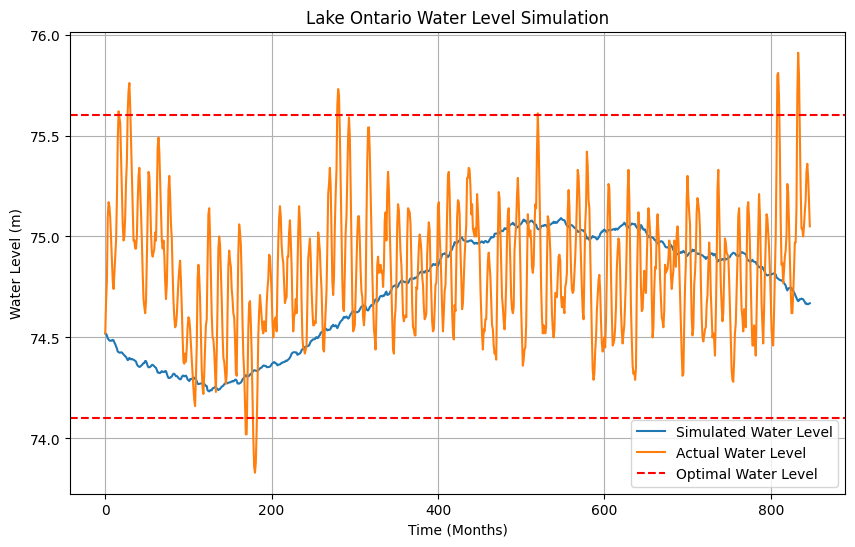

In [48]:
import matplotlib.pyplot as plt

# Function to simulate water level for a lake
def simulate_water_level(lake_df, initial_level, alpha, beta, gamma):
    levels = [initial_level]
    for t in range(1, len(lake_df)):
        precipitation = lake_df.loc[t, "precipitation"]
        evaporation = lake_df.loc[t, "evaporation"]
        flow = lake_df.loc[t, "flow"]
        # Compute water level change
        delta_H = (alpha * precipitation) - (beta * evaporation) - (gamma * flow)
        delta_H = 0.005 * delta_H
        # print(f"t={t}, delta_H={delta_H}, levels[-1]={levels[-1]}")  # Debugging line
        new_level = levels[-1] + delta_H
        levels.append(new_level)
    return levels

# Example: Simulate for Lake Superior
initial_water_level = lake_ontario_df["water level"].iloc[0]
print("Initial water level:", initial_water_level)  # Debugging line
lake_ontario_df["simulated_water_level"] = simulate_water_level(
    lake_ontario_df, initial_water_level, alpha=0.0256, beta=0.0122, gamma=0.00112
)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(lake_ontario_df["simulated_water_level"], label="Simulated Water Level")
plt.plot(lake_ontario_df["water level"], label="Actual Water Level")
plt.axhline(y=74.1, color='red', linestyle='--', label='Optimal Water Level')
plt.axhline(y=75.6, color='red', linestyle='--')
plt.title("Lake Ontario Water Level Simulation")
plt.xlabel("Time (Months)")
plt.ylabel("Water Level (m)")
plt.legend()
plt.grid()
plt.show()


In [49]:
lake_mich_hur_df = df[df['lake'] == 'Michigan-Huron'].reset_index(drop=True)
print(lake_mich_hur_df)

     month  year            lake  water level  evaporation     flow  \
0        1  1950  Michigan-Huron       175.96       101.10  1612.18   
1        2  1950  Michigan-Huron       175.99        89.08   951.42   
2        3  1950  Michigan-Huron       176.02        82.57  2100.59   
3        4  1950  Michigan-Huron       176.17        89.67  3057.59   
4        5  1950  Michigan-Huron       176.27       125.15   868.02   
..     ...   ...             ...          ...          ...      ...   
847      8  2020  Michigan-Huron       177.42       119.69   270.27   
848      9  2020  Michigan-Huron       177.34       128.17  -999.99   
849     10  2020  Michigan-Huron       177.25        74.25  -999.99   
850     11  2020  Michigan-Huron       177.20        90.07  -999.99   
851     12  2020  Michigan-Huron       177.14        98.45  -999.99   

     precipitation  
0           106.56  
1            68.37  
2            66.20  
3            62.78  
4            59.98  
..             ...  


Initial water level: 175.96


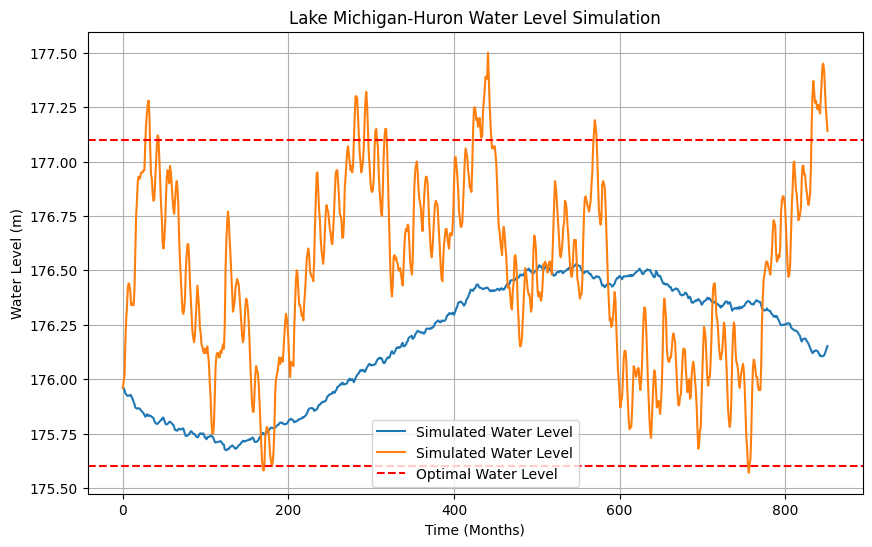

In [50]:
import matplotlib.pyplot as plt

# Function to simulate water level for a lake
def simulate_water_level(lake_df, initial_level, alpha, beta, gamma):
    levels = [initial_level]
    for t in range(1, len(lake_df)):
        precipitation = lake_df.loc[t, "precipitation"]
        evaporation = lake_df.loc[t, "evaporation"]
        flow = lake_df.loc[t, "flow"]
        # Compute water level change
        delta_H = (alpha * precipitation) - (beta * evaporation) - (gamma * flow)
        delta_H = 0.005 * delta_H
        # print(f"t={t}, delta_H={delta_H}, levels[-1]={levels[-1]}")  # Debugging line
        new_level = levels[-1] + delta_H
        levels.append(new_level)
    return levels

# Example: Simulate for Lake Superior
initial_water_level = lake_mich_hur_df["water level"].iloc[0]
print("Initial water level:", initial_water_level)  # Debugging line
lake_mich_hur_df["simulated_water_level"] = simulate_water_level(
    lake_mich_hur_df, initial_water_level, alpha=0.0256, beta=0.0122, gamma=0.00112
)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(lake_mich_hur_df["simulated_water_level"], label="Simulated Water Level")
plt.plot(lake_mich_hur_df["water level"], label="Simulated Water Level")
plt.axhline(y=175.6, color='red', linestyle='--', label='Optimal Water Level')
plt.axhline(y=177.1, color='red', linestyle='--')
plt.title("Lake Michigan-Huron Water Level Simulation")
plt.xlabel("Time (Months)")
plt.ylabel("Water Level (m)")
plt.legend()
plt.grid()
plt.show()


In [51]:
lake_erie_df = df[df['lake'] == 'Erie'].reset_index(drop=True)

print(lake_erie_df)

     month  year  lake  water level  evaporation     flow  precipitation
0        1  1950  Erie       173.90       101.10  1612.18         106.56
1        2  1950  Erie       174.07        89.08   951.42          68.37
2        3  1950  Erie       174.08        82.57  2100.59          66.20
3        4  1950  Erie       174.31        89.67  3057.59          62.78
4        5  1950  Erie       174.36       125.15   868.02          59.98
..     ...   ...   ...          ...          ...      ...            ...
847      8  2020  Erie       174.93       119.69   270.27          84.40
848      9  2020  Erie       174.83       128.17  -999.99          84.43
849     10  2020  Erie       174.72        74.25  -999.99          77.31
850     11  2020  Erie       174.65        90.07  -999.99          98.83
851     12  2020  Erie       174.65        98.45  -999.99          85.05

[852 rows x 7 columns]


Initial water level: 173.9


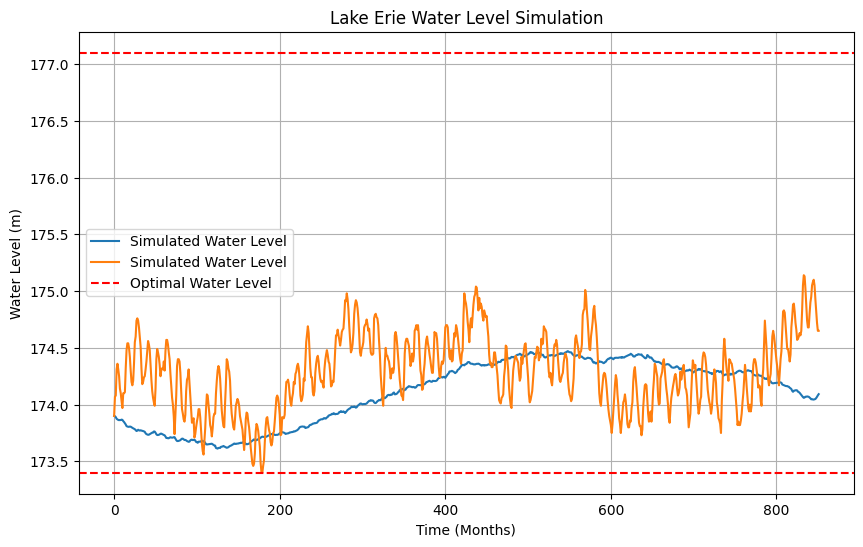

In [52]:
import matplotlib.pyplot as plt

# Function to simulate water level for a lake
def simulate_water_level(lake_df, initial_level, alpha, beta, gamma):
    levels = [initial_level]
    for t in range(1, len(lake_df)):
        precipitation = lake_df.loc[t, "precipitation"]
        evaporation = lake_df.loc[t, "evaporation"]
        flow = lake_df.loc[t, "flow"]
        # Compute water level change
        delta_H = (alpha * precipitation) - (beta * evaporation) - (gamma * flow)
        delta_H = 0.005 * delta_H
        # print(f"t={t}, delta_H={delta_H}, levels[-1]={levels[-1]}")  # Debugging line
        new_level = levels[-1] + delta_H
        levels.append(new_level)
    return levels

# Example: Simulate for Lake Superior
initial_water_level = lake_erie_df["water level"].iloc[0]
print("Initial water level:", initial_water_level)  # Debugging line
lake_erie_df["simulated_water_level"] = simulate_water_level(
    lake_erie_df, initial_water_level, alpha=0.0256, beta=0.0122, gamma=0.00112
)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(lake_erie_df["simulated_water_level"], label="Simulated Water Level")
plt.plot(lake_erie_df["water level"], label="Simulated Water Level")
plt.axhline(y=173.4, color='red', linestyle='--', label='Optimal Water Level')
plt.axhline(y=177.1, color='red', linestyle='--')
plt.title("Lake Erie Water Level Simulation")
plt.xlabel("Time (Months)")
plt.ylabel("Water Level (m)")
plt.legend()
plt.grid()
plt.show()


# Transition Matrix

# This is the transition matrix representing the flow from one lake to another where :
# 1. Lake Superior
# 2. Lake Michigan
# 3. Lake Huron
# 4. Lake Erie
# 5. Lake Ontario

|            | Superior  | Michigan  | Huron   | Erie    | Ontario  |
|------------|-----------|-----------|---------|---------|----------|
| **Superior** | 0.9939    | 0.0       | 0.0065  | 0.0     | 0.0      |
| **Michigan** | 0.0       | 0.9750    | 0.0272  | 0.0     | 0.0      |
| **Huron**    | 0.0061    | 0.0250    | 0.9192  | 0.1041  | 0.0      |
| **Erie**     | 0.0       | 0.0       | 0.0471  | 0.5343  | 0.4283   |
| **Ontario**  | 0.0       | 0.0       | 0.0     | 0.3616  | 0.5717   |


# We will also be using the general recurrence relation : W(n + 1) = P * W(n + 1) - E * W(n + 1) + IF * W(n + 1) - OF * W(n + 1)
# *. P is the percipitation
# *. E is the evaporation
# *. IF is the in flow
# *. OF is the out flow / runoff
# *. W is the water level

# The values for P, E, IF & OF will be random variables based on the average amount of each that occurs for each lake
# We will(can) also add an element of Global Warming using a RV and depending on the value of that RV, the values for the variables will change

# Lake Model VS 2

## Lake Superior Model

In [89]:
df.to_csv('complete lakes df', index=False)
lake_superior_df.to_csv("lake superior df", index = False)

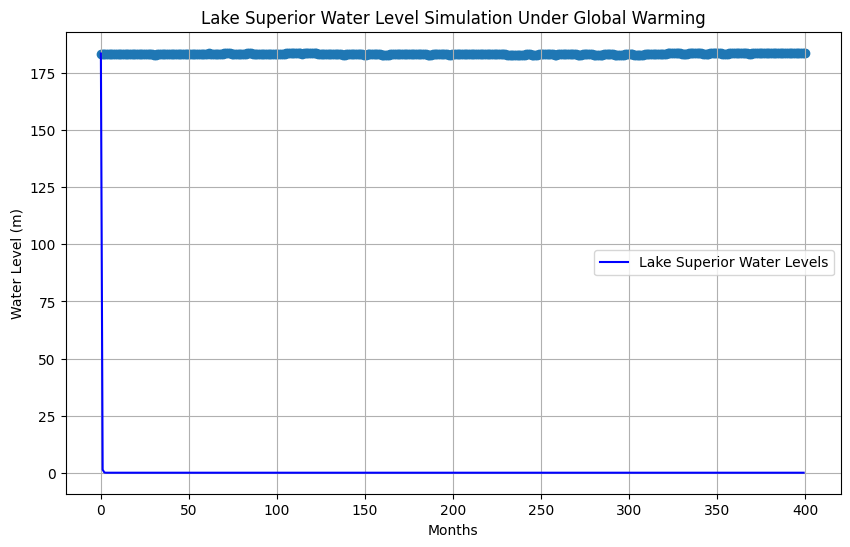

In [316]:
import matplotlib.pyplot as plt
import numpy as np

# Parameters
n = 400  # Number of steps
initial_water_level = 183.53  # Initial water level for Lake Superior

# Define the Random Uniform Variables
p = np.random.uniform(-.0000614, .04, size=n)  # Adjusted precipitation factor
e = np.random.uniform(0.000048, 0.021, size=n)  # Adjusted evaporation factor. Bounds: 25% - 75%
r = 0.0061  # Percent of water from Superior to Huron
inflow = np.random.uniform(.0031, 0.067, size=n)  # Inflow from rivers/other sources

# Global warming element
g = np.random.uniform(0, 1, size=n)

# Initialize water levels
w = [initial_water_level]

# Simulate water levels
for i in range(1, n):
    # Calculate the new water level
    new_level = w[i-1] * (p[i] + inflow[i] - e[i] - r )
    w.append(max(new_level, 0))  # Prevent negative water levels

# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(np.linspace(0, 400, 400), lake_superior_df.iloc[-400:, 3])
plt.plot(range(n), w, label="Lake Superior Water Levels", color='blue')
plt.xlabel("Months")
plt.ylabel("Water Level (m)")
#plt.ylim(180, 185)
plt.title("Lake Superior Water Level Simulation Under Global Warming")
plt.legend()
plt.grid()
plt.show()



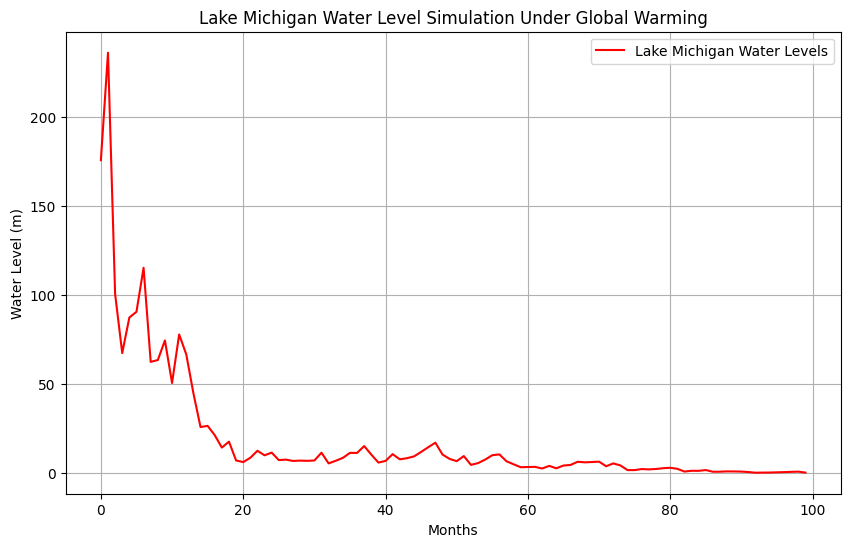

In [285]:
import matplotlib.pyplot as plt
import numpy as np

# Parameters
n = 100  # Number of steps
initial_water_level = 175.6  # Initial water level for Lake Michigan

# Define the Random Uniform Variables
p = np.random.uniform(1, 2, size=n)  # Adjusted precipitation factor
e = np.random.uniform(0.4, 0.7, size=n)  # Adjusted evaporation factor
r = 0.0272  # Percent of water from Michigan to Huron
inflow = np.random.uniform(0.02, 0.1, size=n)  # Inflow from rivers/other sources

# Initialize water levels
w = [initial_water_level]

# Simulate water levels
for i in range(1, n):
    # Calculate the new water level
    new_level = w[i-1] * (p[i] + inflow[i] - e[i] - r)
    w.append(max(new_level, 0))  # Prevent negative water levels

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(range(n), w, label="Lake Michigan Water Levels", color='red')
plt.xlabel("Months")
plt.ylabel("Water Level (m)")
plt.title("Lake Michigan Water Level Simulation Under Global Warming")
plt.legend()
plt.grid()
plt.show()


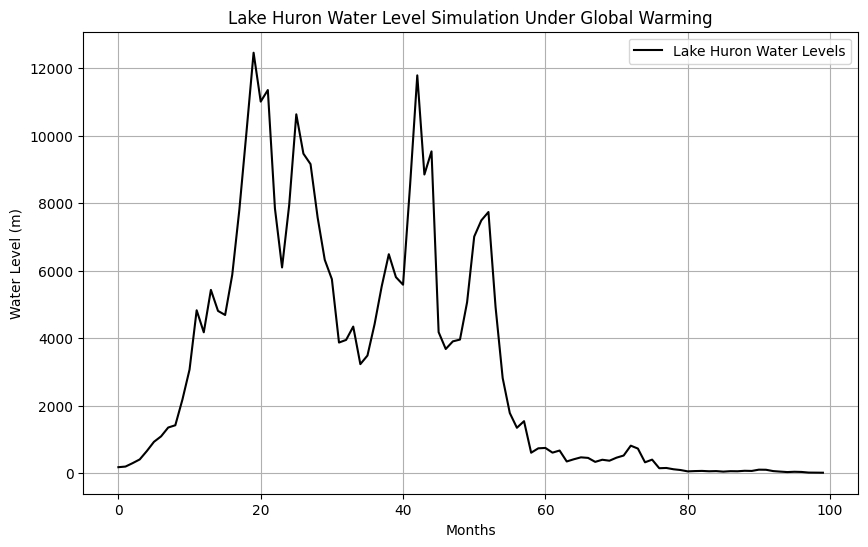

In [349]:
import matplotlib.pyplot as plt
import numpy as np

# Parameters
n = 100  # Number of steps
initial_water_level = 175.6  # Initial water level for Lake Huron

# Define the Random Uniform Variables
p = np.random.uniform(1, 2, size=n)  # Adjusted precipitation factor
e = np.random.uniform(0.3, 0.65, size=n)  # Adjusted evaporation factor
r = 0.1041  # Percent of water from Huron to Erie
inflow = np.random.uniform(0.033, 0.1, size=n)  # Inflow from rivers/other sources

# Initialize water levels
w = [initial_water_level]

# Simulate water levels
for i in range(1, n):
    # Calculate the new water level
    new_level = w[i-1] * (p[i] + inflow[i] - e[i] - r)
    w.append(max(new_level, 0))  # Prevent negative water levels

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(range(n), w, label="Lake Huron Water Levels", color='black')
plt.xlabel("Months")
plt.ylabel("Water Level (m)")
plt.title("Lake Huron Water Level Simulation Under Global Warming")
plt.legend()
plt.grid()
plt.show()


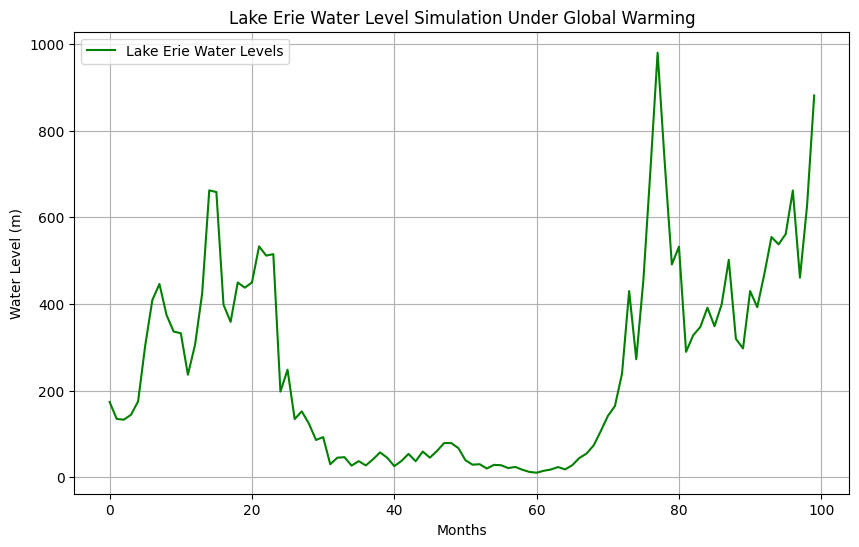

In [348]:
import matplotlib.pyplot as plt
import numpy as np

# Parameters
n = 100  # Number of steps
initial_water_level = 173.4  # Initial water level for Lake Erie

# Define the Random Uniform Variables
p = np.random.uniform(1.2, 2.2, size=n)  # Adjusted precipitation factor
e = np.random.uniform(0.3, 0.8, size=n)  # Adjusted evaporation factor
r = 0.4283  # Percent of water from Erie to Erie
inflow = np.random.uniform(0.5, 0.1, size=n)  # Inflow from rivers/other sources

# Initialize water levels
w = [initial_water_level]

# Simulate water levels
for i in range(1, n):
    # Calculate the new water level
    new_level = w[i-1] * (p[i] + inflow[i] - e[i] - r)
    w.append(max(new_level, 0))  # Prevent negative water levels

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(range(n), w, label="Lake Erie Water Levels", color='green')
plt.xlabel("Months")
plt.ylabel("Water Level (m)")
plt.title("Lake Erie Water Level Simulation Under Global Warming")
plt.legend()
plt.grid()
plt.show()


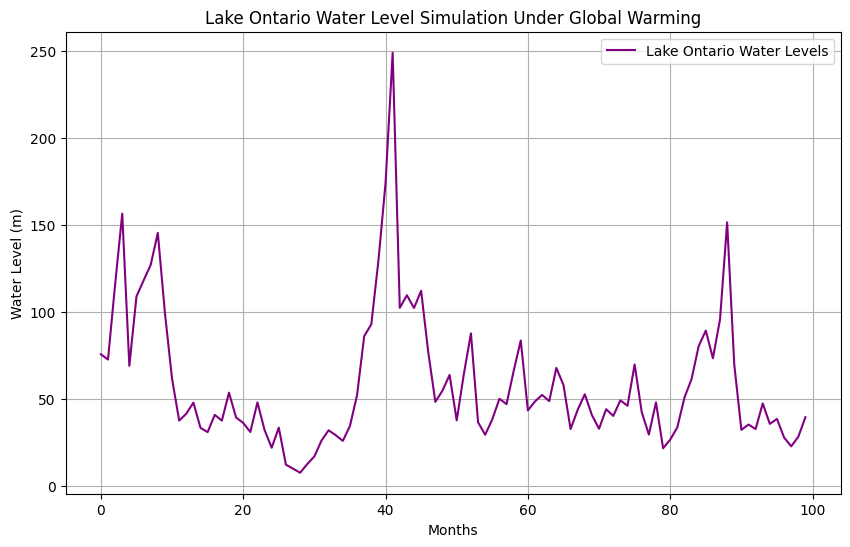

In [290]:
import matplotlib.pyplot as plt
import numpy as np

# Parameters
n = 100  # Number of steps
initial_water_level = 75.6  # Initial water level for Lake Ontario

# Define the Random Uniform Variables
p = np.random.uniform(1.2, 2.2, size=n)  # Adjusted precipitation factor
e = np.random.uniform(0.3, 0.8, size=n)  # Adjusted evaporation factor
r = 0.3616  # Percent of water from Ontario to the world
inflow = np.random.uniform(0.3616, 0.1, size=n)  # Inflow from rivers/other sources

# Initialize water levels
w = [initial_water_level]

# Simulate water levels
for i in range(1, n):
    # Calculate the new water level
    new_level = w[i-1] * (p[i] + inflow[i] - e[i] - r)
    w.append(max(new_level, 0))  # Prevent negative water levels

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(range(n), w, label="Lake Ontario Water Levels", color='purple')
plt.xlabel("Months")
plt.ylabel("Water Level (m)")
plt.title("Lake Ontario Water Level Simulation Under Global Warming")
plt.legend()
plt.grid()
plt.show()


# Lake Model VS 3 (FINAL)

#### Lake Superior

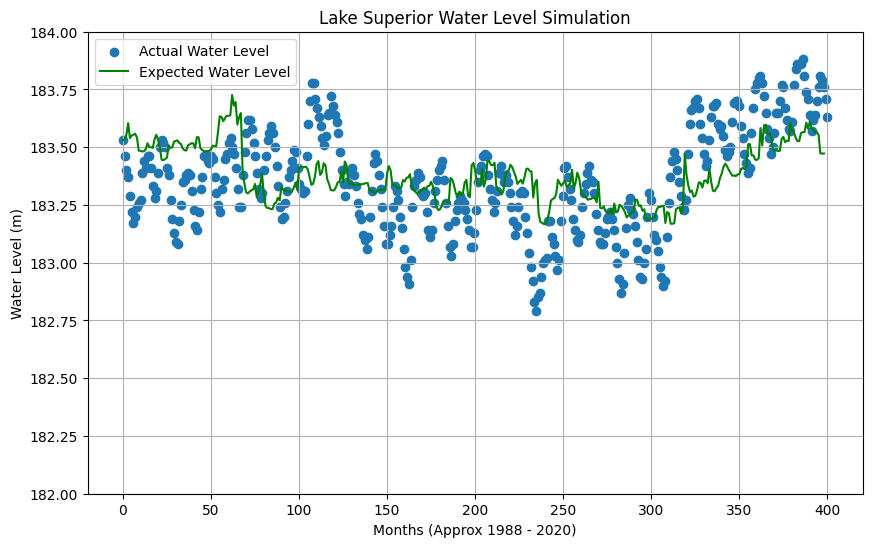

In [375]:
superior = lake_superior_df
# Parameters
n = 399  # Number of steps
initial_water_level = 183.53  # Initial water level for Lake Superior

# Initialize water levels
w = [initial_water_level]

# Consider Factors
p = (superior['precipitation'].iloc[-400:].reset_index(drop = True) / 1000).diff().dropna().reset_index(drop = True)
inflow = (superior['flow'].iloc[-400:].reset_index(drop = True) / 1000).diff().dropna().reset_index(drop = True)
e = (superior['evaporation'].iloc[-400:].reset_index(drop = True) / 1000).diff().dropna().reset_index(drop = True)
r = 0.0061

# Stochastic RV for Runoff
alpha = np.random.uniform(-0.000019,0)
beta = np.random.uniform(0,0.00073)
gamma = np.random.uniform(-0.000366, 0)
tau = np.random.uniform(0, 0.0001)

# Simulate water levels
for i in range(1, n):
    # Calculate the new water level
    gamma = np.random.uniform(0, 0.1)
    new_level = w[i-1] + alpha * p[i-1] - beta * e[i-1] + gamma * inflow[i-1] - tau * r * w[i-1]

    w.append(max(new_level, 0))  # Prevent negative water levels

# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(np.linspace(0, 400, 400), superior.iloc[-400:, 3], label = "Actual Water Level")
plt.plot(range(n), w, label="Expected Water Level", color='green')
plt.xlabel("Months (Approx 1988 - 2020)")
plt.ylabel("Water Level (m)")
plt.ylim(182, 184)
plt.title("Lake Superior Water Level Simulation")
plt.legend()
plt.grid()
plt.show()



#### Lake Michigan

In [386]:
michigan = lake_mich_hur_df
michigan.iloc[-400,:]

month                                 9
year                               1987
lake                     Michigan-Huron
water level                       176.9
evaporation                       69.25
flow                             462.91
precipitation                     92.83
simulated_water_level         176.41472
Name: 452, dtype: object

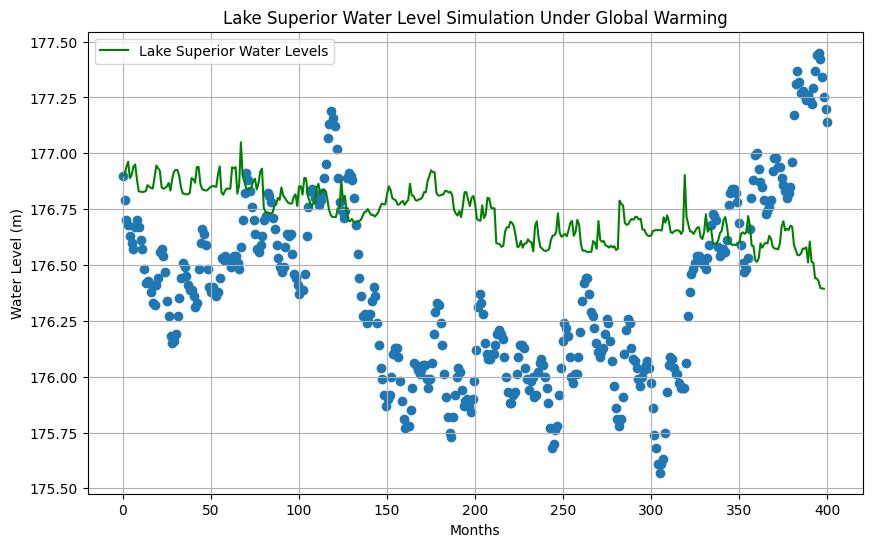

In [449]:
import matplotlib.pyplot as plt
import numpy as np

# Parameters
n = 399  # Number of steps
initial_water_level = 176.9  # Initial water level for Lake Superior

# Initialize water levels
w = [initial_water_level]

# Consider Factors
p = (michigan['precipitation'].iloc[-400:].reset_index(drop = True) / 1000).diff().dropna().reset_index(drop = True)
inflow = (michigan['flow'].iloc[-400:].reset_index(drop = True) / 1000).diff().dropna().reset_index(drop = True)
e = (michigan['evaporation'].iloc[-400:].reset_index(drop = True) / 1000).diff().dropna().reset_index(drop = True)
r = 0.025


# Stochastic RV for Runoff
alpha = np.random.uniform(-0.000019,0)
beta = np.random.uniform(0,0.00073)
gamma = np.random.uniform(-0.000366, 0)
tau = np.random.uniform(0, 0.001)

# Simulate water levels
for i in range(1, n):
    # Calculate the new water level
    gamma = np.random.uniform(0, 0.1)
    new_level = w[i-1] + alpha * p[i-1] - beta * e[i-1] + gamma * inflow[i-1] - tau * r * w[i-1]

    w.append(max(new_level, 0))  # Prevent negative water levels

# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(np.linspace(0, 400, 400), michigan.iloc[-400:, 3])
plt.plot(range(n), w, label="Lake Superior Water Levels", color='green')
plt.xlabel("Months")
plt.ylabel("Water Level (m)")
plt.title("Lake Superior Water Level Simulation Under Global Warming")
plt.legend()
plt.grid()
plt.show()

